In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src.room_and_object_types import CATEGORIES_TO_TYPES, EMPTY_OBJECT
from src.fitness_features import COMMON_SENSE_PREDICATES_FUNCTIONS, PREDICATE_FUNCTION_ARITY_MAP
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..')
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [4]:
fitness_df = utils.load_fitness_data()
fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'))
fitness_df = fitness_df[list(fitness_df.columns[:4]) + list(fitness_df.columns[-2:]) + list(fitness_df.columns[4:-2])]
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1.0,1.0,1.0,1.00,...,0,0,1,0,0,1,0,0,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1.0,1.0,1.0,1.00,...,0,0,1,0,0,0,0,0,1,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1.0,1.0,1.0,0.00,...,1,0,0,0,0,0,1,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1.0,1.0,1.0,0.00,...,1,0,0,0,0,1,0,0,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1.0,1.0,1.0,0.25,...,1,0,0,0,0,0,0,1,0,0


In [5]:
BINARIZE_IGNORE_FEATURES = [
    'setup_objects_used', 'starts_and_ends_once', 'correct_predicate_function_arity',
    'section_without_pref_count_terminal', 'section_without_pref_count_scoring'
]  

BINARIZE_IGNORE_PATTERNS = [
    re.compile(r'max_depth_[\w\d_]+'), 
    re.compile(r'mean_depth_[\w\d_]+'), 
    re.compile(r'node_count_[\w\d_]+')
]  

BINARIZE_NON_ONE = [
    'all_variables_defined', 'all_variables_used', 
    'all_preferences_used', 'no_adjacent_once', 'variable_not_repeated',
    'no_nested_logicals', 'no_identical_logical_children',     
    'count_once_per_external_objects_used_correctly',         
    'external_forall_used_correctly', 'pref_forall_used',        
    'pref_forall_correct_arity', 'pref_forall_correct_types', 'no_two_number_operations'
]  

BINRARIZE_NONZERO_PATTERNS = [
    re.compile(r'arg_types_[\w_]+'), 
    re.compile(r'compositionality_structure_\d+')
]   

def binarize_features(df: pd.DataFrame, ignore_columns: typing.Iterable[str] = NON_FEATURE_COLUMNS) -> pd.DataFrame:
    binarized_df = df.copy(deep=True)

    for c in binarized_df.columns:
        if c in ignore_columns:
            continue

        if c in BINARIZE_IGNORE_FEATURES:
            continue 
        
        if any([p.match(c) for p in BINARIZE_IGNORE_PATTERNS]):
            continue

        if c in BINARIZE_NON_ONE:
            binarized_df[c] = (binarized_df[c] == 1).astype(int)

        if any([p.match(c) for p in BINRARIZE_NONZERO_PATTERNS]):
            binarized_df[c] = (binarized_df[c] != 0).astype(int)

    return binarized_df


binarized_df = binarize_features(fitness_df)

In [6]:
binarized_df.head()

,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1,1,1,1.00,...,0,0,1,0,0,1,0,0,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1,1,1,1.00,...,0,0,1,0,0,0,0,0,1,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1,1,1,0.00,...,1,0,0,0,0,0,1,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1,1,1,0.00,...,1,0,0,0,0,1,0,0,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1,1,1,0.25,...,1,0,0,0,0,0,0,1,0,0


In [7]:
with open('../data/features_with_weight_above_threshold_2022_01_24.txt', 'r') as f:
    features_with_weight_above_threshold = f.read().splitlines()

In [8]:
def create_interaction_features_df(df: pd.DataFrame, relevant_features: typing.Iterable[str], interaction_function: typing.Callable = np.multiply) -> pd.DataFrame:
    interaction_features_df = pd.concat([df[key] for key in list(NON_FEATURE_COLUMNS) + list(relevant_features)], axis=1)

    interaction_features = [interaction_features_df]

    for f1, f2 in itertools.combinations(relevant_features, 2):
        feature = interaction_function(df[f1], df[f2])
        feature.name = f'{f1}_x_{f2}'
        interaction_features.append(feature)

    interaction_features_df = pd.concat(interaction_features, axis=1)
    return interaction_features_df

In [9]:
interactions_df = create_interaction_features_df(binarized_df, features_with_weight_above_threshold)
print(interactions_df.shape)
interactions_df.head()

(6370, 10591)


,Index,real,domain_name,game_name,original_game_name,src_file,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_constraints_4_x_node_count_terminal_0,node_count_constraints_4_x_node_count_terminal_2,node_count_constraints_4_x_node_count_terminal_3,node_count_constraints_4_x_node_count_scoring_4,node_count_terminal_0_x_node_count_terminal_2,node_count_terminal_0_x_node_count_terminal_3,node_count_terminal_0_x_node_count_scoring_4,node_count_terminal_2_x_node_count_terminal_3,node_count_terminal_2_x_node_count_scoring_4,node_count_terminal_3_x_node_count_scoring_4
0,0,1,medium-objects-room-v1,6172feb1665491d1efbce164-0,6172feb1665491d1efbce164-0,interactive-beta.pddl,1,1,1,1.00,...,0,0,0,0,0,0,0,0,0,0
1,1,1,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,5f77754ba932fb2c4ba181d8-2,interactive-beta.pddl,1,1,1,1.00,...,0,0,0,0,0,0,0,0,0,0
2,2,1,many-objects-room-v1,614b603d4da88384282967a7-3,614b603d4da88384282967a7-3,interactive-beta.pddl,1,1,1,0.00,...,0,0,0,0,0,0,0,0,0,0
3,3,1,few-objects-room-v1,5bc79f652885710001a0e82a-5,5bc79f652885710001a0e82a-5,interactive-beta.pddl,1,1,1,0.00,...,0,0,0,0,0,0,0,0,0,0
4,4,1,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,614dec67f6eb129c3a77defd-6,interactive-beta.pddl,1,1,1,0.25,...,0,0,0,0,0,0,0,0,0,0


Train tensor shape: torch.Size([78, 65, 10585]) | Test tensor shape: torch.Size([20, 65, 10585])
Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### Test results:

{'ecdf': -0.18457692307692306, 'game_rank': 0.8023437261581421}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
1276,16,64,<function fitness_square_square_loss at 0x15c3...,0.003,8,10585,0.00,-0.166469,0.020285,1,0.823633,0.017206,2
892,8,32,<function fitness_square_square_loss at 0x15c3...,0.003,8,10585,0.00,-0.173436,0.020869,2,0.822096,0.018015,6
824,8,16,<function fitness_square_square_loss at 0x15c3...,0.003,4,10585,0.00,-0.173485,0.022447,3,0.821510,0.019934,7
956,8,64,<function fitness_square_square_loss at 0x15c3...,0.003,8,10585,0.00,-0.174078,0.024898,4,0.824492,0.018202,1
1277,16,64,<function fitness_square_square_loss at 0x15c3...,0.003,8,10585,0.25,-0.174658,0.020894,5,0.819883,0.021108,9
888,8,32,<function fitness_square_square_loss at 0x15c3...,0.003,4,10585,0.00,-0.174739,0.020679,6,0.819701,0.020568,10
952,8,64,<function fitness_square_square_loss at 0x15c3...,0.003,4,10585,0.00,-0.175050,0.025340,7,0.822708,0.020638,4
880,8,32,<function fitness_square_square_loss at 0x15c3...,0.003,1,10585,0.00,-0.176017,0.018324,8,0.811445,0.016055,34
828,8,16,<function fitness_square_square_loss at 0x15c3...,0.003,8,10585,0.00,-0.176086,0.018409,9,0.822669,0.018135,5
953,8,64,<function fitness_square_square_loss at 0x15c3...,0.003,4,10585,0.25,-0.176111,0.022299,10,0.821081,0.018554,8


### CV results by mean single game rank:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
956,8,64,<function fitness_square_square_loss at 0x15c3...,0.003,8,10585,0.00,-0.174078,0.024898,4,0.824492,0.018202,1
1276,16,64,<function fitness_square_square_loss at 0x15c3...,0.003,8,10585,0.00,-0.166469,0.020285,1,0.823633,0.017206,2
957,8,64,<function fitness_square_square_loss at 0x15c3...,0.003,8,10585,0.25,-0.178205,0.022148,11,0.823294,0.018480,3
952,8,64,<function fitness_square_square_loss at 0x15c3...,0.003,4,10585,0.00,-0.175050,0.025340,7,0.822708,0.020638,4
828,8,16,<function fitness_square_square_loss at 0x15c3...,0.003,8,10585,0.00,-0.176086,0.018409,9,0.822669,0.018135,5
892,8,32,<function fitness_square_square_loss at 0x15c3...,0.003,8,10585,0.00,-0.173436,0.020869,2,0.822096,0.018015,6
824,8,16,<function fitness_square_square_loss at 0x15c3...,0.003,4,10585,0.00,-0.173485,0.022447,3,0.821510,0.019934,7
953,8,64,<function fitness_square_square_loss at 0x15c3...,0.003,4,10585,0.25,-0.176111,0.022299,10,0.821081,0.018554,8
1277,16,64,<function fitness_square_square_loss at 0x15c3...,0.003,8,10585,0.25,-0.174658,0.020894,5,0.819883,0.021108,9
888,8,32,<function fitness_square_square_loss at 0x15c3...,0.003,4,10585,0.00,-0.174739,0.020679,6,0.819701,0.020568,10


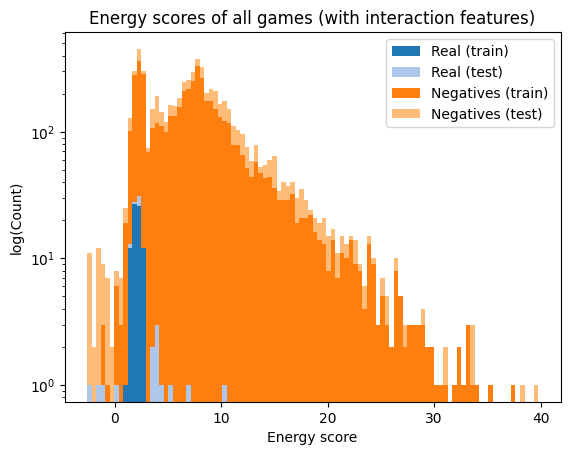

0.01348534 0.058387216 4.623871


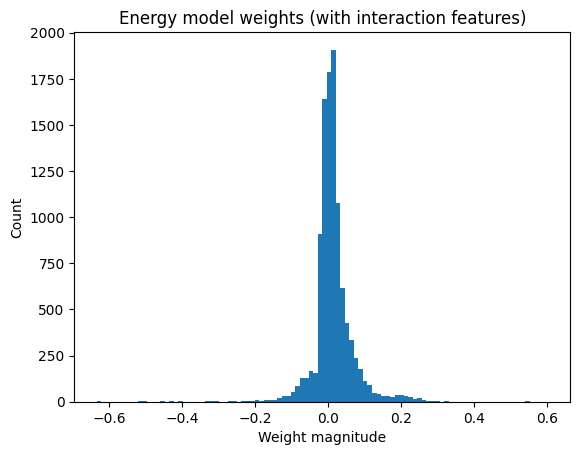

In [10]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_square_square_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },   
]

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv_interactions_sq_sq, (train_tensor_interactions_sq_sq, test_tensor_interactions_sq_sq), test_results_interactions_sq_sq = utils.model_fitting_experiment(interactions_df, test_param_grid,
    scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs,
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


utils.visualize_cv_outputs(cv_interactions_sq_sq, train_tensor_interactions_sq_sq, test_tensor_interactions_sq_sq, test_results_interactions_sq_sq, histogram_title_note='with interaction features')

In [11]:
weights = cv_interactions_sq_sq.best_estimator_.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
feature_columns = [c for c in interactions_df.columns if c not in NON_FEATURE_COLUMNS]

K = 20
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('### Features with largest negative weights (most predictive of real games:')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('### Features with largest positive weights (most predictive of fake games:')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


### Features with largest negative weights (most predictive of real games:
1. variable_not_repeated_x_pref_forall_used (-0.6328)
2. all_variables_used_x_variable_not_repeated (-0.6230)
3. all_variables_used_x_pref_forall_used (-0.5943)
4. variable_not_repeated_x_pref_forall_correct_types (-0.5784)
5. all_variables_used_x_pref_forall_correct_types (-0.5698)
6. pref_forall_used_x_pref_forall_correct_types (-0.5160)
7. variable_not_repeated_x_no_two_number_operations (-0.5152)
8. variable_not_repeated_x_no_nested_logicals (-0.5025)
9. all_variables_defined_x_variable_not_repeated (-0.5003)
10. all_variables_used_x_no_two_number_operations (-0.4971)
11. all_variables_used_x_no_nested_logicals (-0.4967)
12. no_nested_logicals_x_pref_forall_used (-0.4835)
13. pref_forall_used_x_no_two_number_operations (-0.4623)
14. variable_not_repeated_x_pref_forall_correct_arity (-0.4598)
15. pref_forall_correct_types_x_no_two_number_operations (-0.4553)
16. no_nested_logicals_x_pref_forall_correct_types (-0.4502)
17. all_preferences_used_x_variable_not_repeated (-0.4501)
18. all_variables_used_x_pref_forall_correct_arity (-0.4434)
19. all_variables_used_x_all_preferences_used (-0.4271)
20. no_nested_logicals_x_no_two_number_operations (-0.4264)
### Features with largest positive weights (most predictive of fake games:
1. correct_predicate_function_arity (0.6013)
2. count_once_per_external_objects_used_correctly (0.5505)
3. count_once_per_external_objects_used_correctly_x_correct_predicate_function_arity (0.5435)
4. external_forall_used_correctly (0.4641)
5. external_forall_used_correctly_x_correct_predicate_function_arity (0.4531)
6. count_once_per_external_objects_used_correctly_x_external_forall_used_correctly (0.3778)
7. arg_types_agent_holds_balls (0.3296)
8. correct_predicate_function_arity_x_arg_types_agent_holds_balls (0.3241)
9. arg_types_agent_holds_balls_x_arg_types_in_motion_receptacles (0.3143)
10. mean_depth_constraints_2 (0.3009)
11. arg_types_in_motion_balls_x_arg_types_in_motion_receptacles (0.2965)
12. correct_predicate_function_arity_x_mean_depth_constraints_2 (0.2900)
13. pref_forall_correct_arity_x_arg_types_in_motion_receptacles (0.2878)
14. correct_predicate_function_arity_x_arg_types_in_motion_balls (0.2868)
15. count_once_per_external_objects_used_correctly_x_arg_types_in_motion_receptacles (0.2828)
16. correct_predicate_function_arity_x_node_count_terminal_2 (0.2762)
17. all_variables_defined_x_arg_types_in_motion_receptacles (0.2732)
18. count_once_per_external_objects_used_correctly_x_arg_types_agent_holds_room_features (0.2709)
19. correct_predicate_function_arity_x_max_depth_setup_2 (0.2695)
20. arg_types_in_motion_balls (0.2658)